# Camera Calibration
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Calibration images are stored in the directory "camera_cal".  Output images are placed in the directory "output_images".

The distortion coefficients are save in a pickle for later use.

In [1]:
import numpy as np
import cv2
import glob
import pickle

# Prep the obj points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# init the arrays for object points (3D) and image points (2D)
objpoints = []
imgpoints = []

# create a list of the calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the corners of each checkerboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        print('Current file: ', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the corner and display
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = './output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save calibration for future retrieval
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump( dist_pickle, open( './calibration_pickle.p', 'wb'))

Current file:  ./camera_cal/calibration9.jpg
Current file:  ./camera_cal/calibration2.jpg
Current file:  ./camera_cal/calibration14.jpg
Current file:  ./camera_cal/calibration20.jpg
Current file:  ./camera_cal/calibration18.jpg
Current file:  ./camera_cal/calibration10.jpg
Current file:  ./camera_cal/calibration8.jpg
Current file:  ./camera_cal/calibration17.jpg
Current file:  ./camera_cal/calibration6.jpg
Current file:  ./camera_cal/calibration3.jpg
Current file:  ./camera_cal/calibration19.jpg
Current file:  ./camera_cal/calibration12.jpg
Current file:  ./camera_cal/calibration7.jpg
Current file:  ./camera_cal/calibration11.jpg
Current file:  ./camera_cal/calibration15.jpg
Current file:  ./camera_cal/calibration16.jpg
Current file:  ./camera_cal/calibration13.jpg


# Test the calibration
Use distortion coefficients generated in the previous cell to undistort sample images

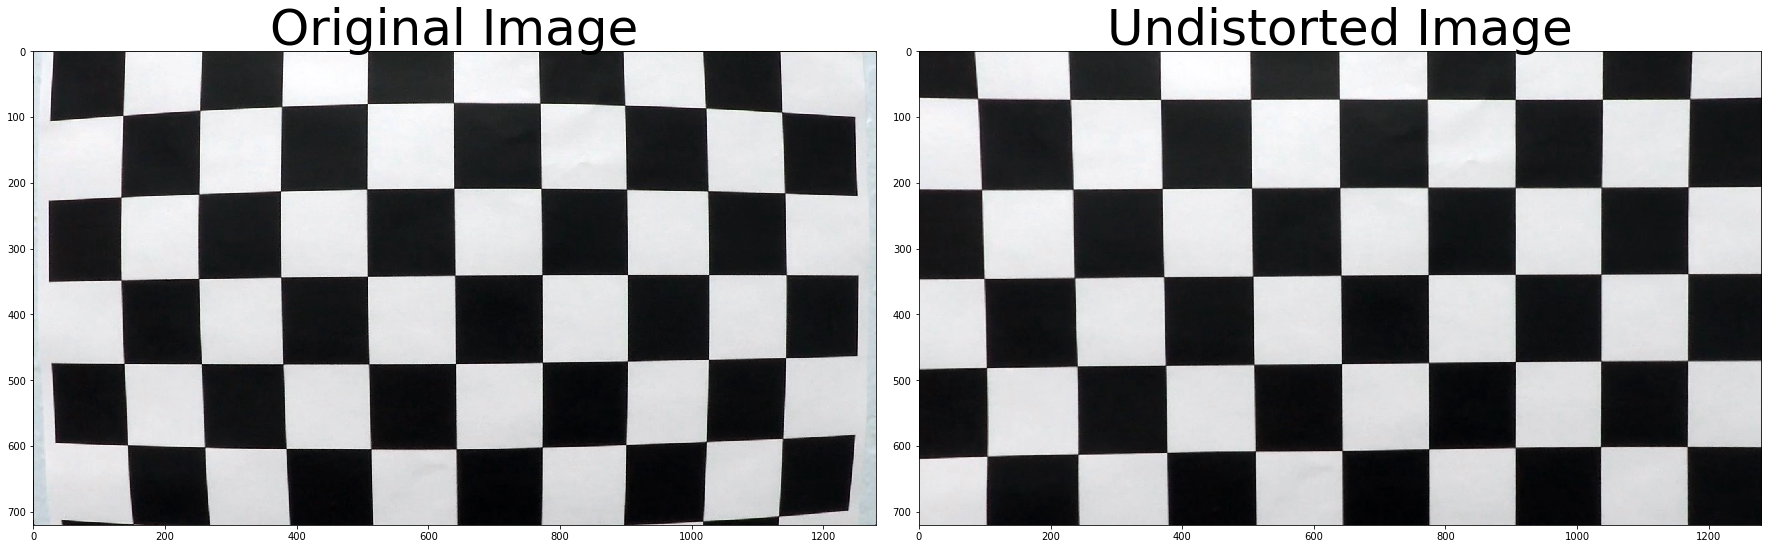

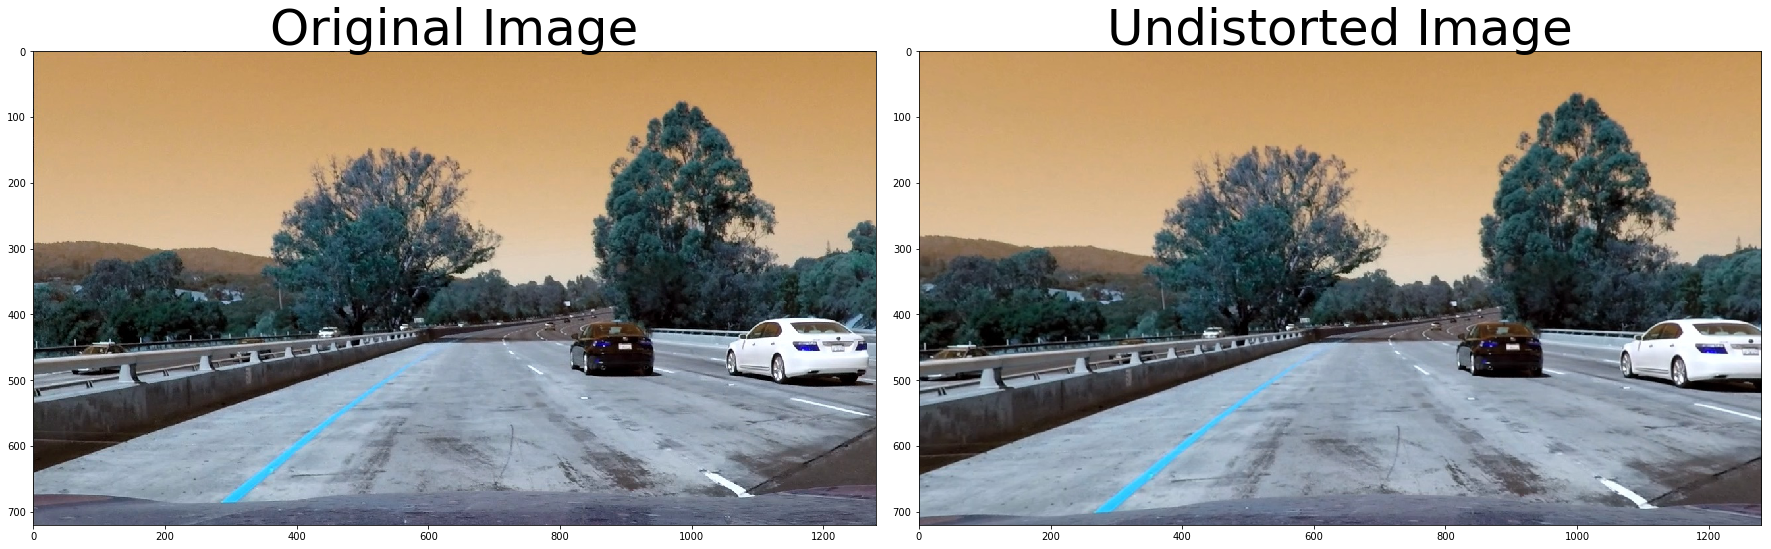

In [3]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt

# Retrieve the distortion coefficients that were saved in a pickle in the previous cell
dist_pickle = pickle.load ( open( './calibration_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# test on a checkboard
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undistort = cv2.undistort(img, mtx, dist, None, mtx)
write_name = './output_images/undistorted_checkerboard.jpg'
cv2.imwrite(write_name, undistort)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# test on a sample image      
img = cv2.imread('./test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undistort = cv2.undistort(img, mtx, dist, None, mtx)
write_name = './output_images/undistorted_test1.jpg'
cv2.imwrite(write_name, undistort)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Create a thresholded binary image
Use color transforms, gradients, etc., to create a thresholded binary image

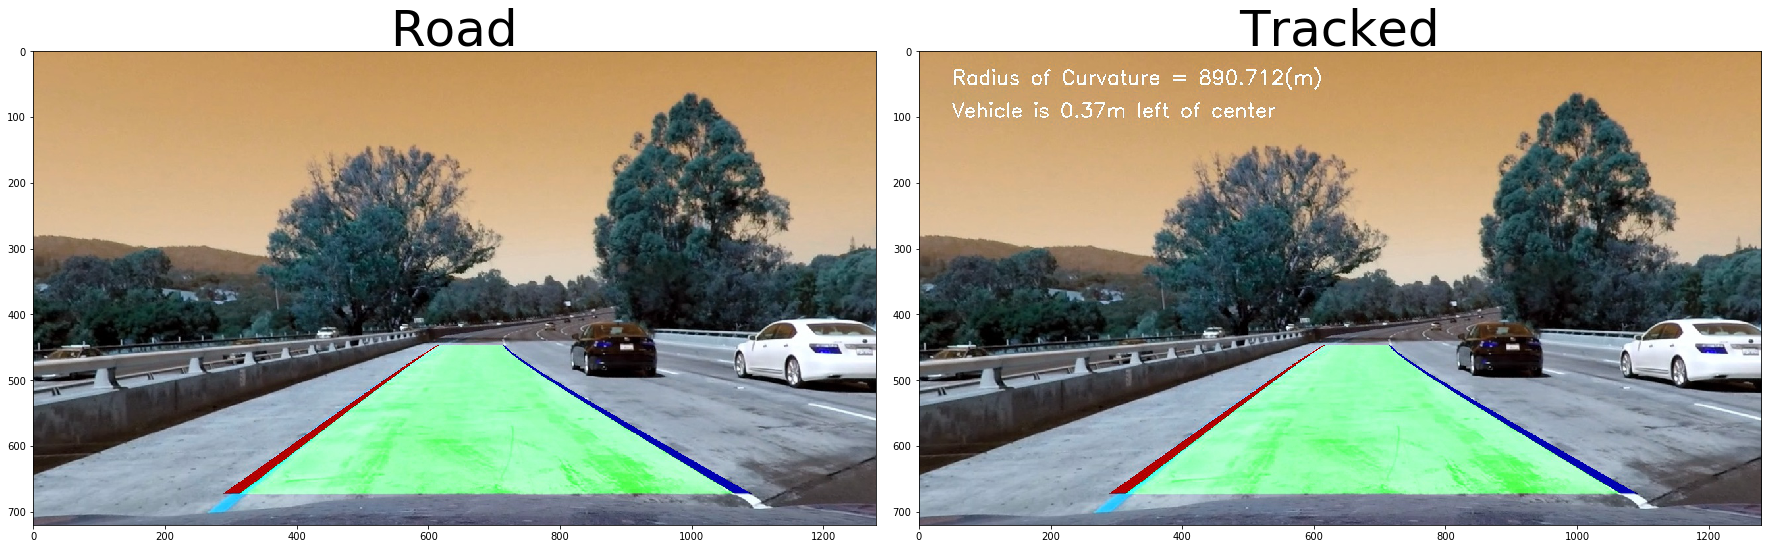

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import os

# Retrieve the distortion coefficients that were saved in a pickle in the previous cell
dist_pickle = pickle.load ( open( './calibration_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Define a function that takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Calculate the magnitude
    abs_sobel = np.sqrt(np.square(abs_sobelx)+np.square(abs_sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # trap any errors
    with np.errstate(divide='ignore', invalid='ignore'):
        # 3) Take the absolute value of the x and y gradients
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        # 5) Create a binary mask where direction thresholds are met
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Color threshold using R(ed) (HL)S and (HS)V
def color_threshold(image, rthresh=(0,255), sthresh=(0,255), vthresh=(0,255)):
    # 2nd submission - added Red thresholding
    r = image[:,:,0]
    r_binary = np.zeros_like(r)
    r_binary[(r > rthresh[0]) & (r <= rthresh[1])]
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel>=vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    #output[(r_binary == 1) & (s_binary == 1) & (v_binary == 1)] = 1
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output
 
# 2nd submission - localized this function instead of having it in a class
def find_window_centroids(warped, window_width, window_height, margin, smooth_factor):    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    recent_centers.append(window_centroids)
    
    return np.average(recent_centers[-smooth_factor:], axis = 0)

def process_image(img, save_int_files=False):
    
    # undisort it
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2nd submission - option to save files
    if save_int_files:
        write_name = './output_images/undistorted_'+ os.path.basename(fname)
        cv2.imwrite(write_name, img)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    binary = np.zeros_like(img[:,:,0])
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255))
    grady = abs_sobel_thresh(img, orient='y', thresh=(25,100))
    color_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    # default thresholds so nothing really happening in this one
    mag_binary = mag_thresh(img, sobel_kernel=ksize)
    # default thresholds so nothing really happening in this one
    dir_binary = dir_threshold(img, sobel_kernel=ksize)
    
    # combine the thresholds into a thresholded binary image
    binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & color_binary == 1)] = 255
    
    # 2nd submission - option to save files
    if save_int_files:
        write_name = './output_images/binary_'+ os.path.basename(fname)
        cv2.imwrite(write_name, binary)
    
    # define the trapizoid shape for the src
    img_size = (img.shape[1], img.shape[0])
    bot_width = .70 # percent of bottom trapizoid width
    mid_width = .08 # percent of middle trapizoid width
    height_pct = .62 # percent for trapizoid height 
    bottom_trim = .935 # percent from top to bottom to avoid car hood

    # src and dst vertice order must match - these are clockwise from the top left
    src = np.float32([[img.shape[1]*(.5-mid_width/2), img.shape[0]*height_pct], [img.shape[1]*(.5+mid_width/2), img.shape[0]*height_pct], [img.shape[1]*(.5+bot_width/2), img.shape[0]*bottom_trim], [img.shape[1]*(.5-bot_width/2), img.shape[0]*bottom_trim]])
    # 2nd submission -  multiplier changed from .25 to make the lane fill more of the destination
    offset = img_size[0] * .15
    # dst is a rectangle
    dst = np.float32([[offset,0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # 2nd submission - option to save files
    if save_int_files:
        write_name = './output_images/warped_'+ os.path.basename(fname)
        cv2.imwrite(write_name, warped)
    
    window_width = 25
    window_height = 80
    
    # 2nd submission - localized this function instead of having it in a class
    #    Changed smoothing factor from 15 to 0 because lanes that bent quickly wented being properly marked
    #    Changed margin from 25 to 50
    window_centroids = find_window_centroids(warped, window_width, window_height, 50, 15)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # centers
    rightx = []
    leftx = []
    
    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # add center value to the list
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    lanes = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
    # 2nd submission - option to save files
    if save_int_files:
        write_name = './output_images/lanes_'+ os.path.basename(fname)
        cv2.imwrite(write_name, lanes)
    
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    
    # add the lane markers to the road
    road = np.zeros_like(img)
    # add lane lines in the overhead perspective
    cv2.fillPoly(road,[left_lane], color=[255,0,0])
    cv2.fillPoly(road,[right_lane], color=[0,0,255])
    cv2.fillPoly(road,[middle_marker], color=[0,255,0])
    # put the image back to normal perspective (unwarp)
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    road_bkg = np.zeros_like(img)
    # draw the lanes in black for emphasis (makes them stand out more when combined with the single color overlay)
    cv2.fillPoly(road_bkg,[left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane], color=[255,255,255])
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    # Add the orignal image, the base (for empahsis) and the lane markers
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)
    
    # 2nd submission - option to save files
    if save_int_files:
        write_name = './output_images/roadwarped_'+ os.path.basename(fname)
        cv2.imwrite(write_name, result)
    
    # meters per pixel for scaling
    # 2nd submission - updated values based on feedback (defaults used previously, I think)
    xm_per_pix = 3.7/500
    ym_per_pix = 30/720
    
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # find the car (wrt the road)
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center - warped.shape[1]/2)*xm_per_pix
    # 2nd submission - Left and right were swapped!
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    cv2.putText(result, 'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    # 2nd submission - option to save files
    if save_int_files:
        write_name = './output_images/tracked_'+ os.path.basename(fname)
        cv2.imwrite(write_name, result)
    
    return result

images = glob.glob('./test_images/test*.jpg')

for idx, fname in enumerate(images):
    # read an image
    img = cv2.imread(fname)
    
    # 2nd submission - added outside of the find_window_centroids for storing multiple instances (for averaging)
    #   Reset for each new image
    recent_centers = []
    process_image(img, True)

# display the first one
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# read an image
img = cv2.imread('./output_images/roadwarped_test1.jpg')
ax1.imshow(img)
ax1.set_title('Road', fontsize=50)
# read an image
img = cv2.imread('./output_images/tracked_test1.jpg')
ax2.imshow(img)
ax2.set_title('Tracked', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Process Video
Use function developed above to process video clips
NOTE: Intermediate saving of files during processing defaults to false

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import glob
import pickle
import os

# 2nd submission - discovered that code and variables from above cell could be used without redefining them
#   I deleted them from this cell eliminating redundancy

# 2nd submission - Reset for video processing
recent_centers = []

Output_video = 'output1_tracked.mp4'
Input_video = 'project_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video output1_tracked.mp4
[MoviePy] Writing video output1_tracked.mp4


100%|█████████▉| 1260/1261 [08:47<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1_tracked.mp4 

